In [1]:
try:
    import google.colab  # noqa: F401

    !pip install -q daml[torch] torchmetrics torchvision
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia
except Exception:
    pass

!pip install -q tabulate

import os

from pytest import approx

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
from typing import Dict, Sequence, cast

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision.datasets as datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader, Dataset, Subset

from daml.metrics import Sufficiency

np.random.seed(0)
np.set_printoptions(formatter={"float": lambda x: f"{x:0.4f}"})
torch.manual_seed(0)
torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
datasets.MNIST("./data", train=True, download=True)
datasets.MNIST("./data", train=False, download=True)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [4]:
# Download the mnist dataset and preview the images
to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_ds = datasets.MNIST("./data", train=True, download=True, transform=to_tensor)
test_ds = datasets.MNIST("./data", train=False, download=True, transform=to_tensor)

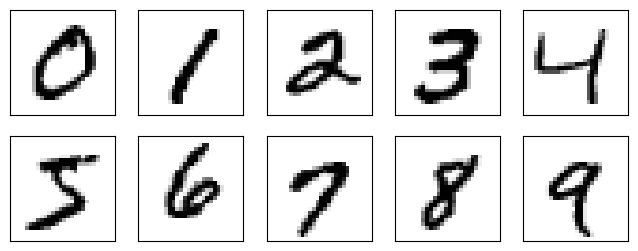

In [5]:
fig = plt.figure(figsize=(8, 3))

for lbl in range(10):
    i = (train_ds.targets == lbl).nonzero()[0][0]
    img = train_ds.data[i]
    ax = fig.add_subplot(2, 5, lbl + 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img, cmap="gray_r")

In [6]:
# Take a subset of 2000 training images and 500 test images
train_ds = Subset(train_ds, range(2000))
test_ds = Subset(test_ds, range(500))

In [7]:
# Define our network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Compile the model
model = torch.compile(Net().to(device))

# Type cast the model back to Net as torch.compile returns a Unknown
# Nothing internally changes from the cast; we are simply signaling the type
model = cast(Net, model)

In [8]:
def custom_train(model: nn.Module, dataset: Dataset, indices: Sequence[int]):
    # Defined only for this testing scenario
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epochs = 10

    # Define the dataloader for training
    dataloader = DataLoader(Subset(dataset, indices), batch_size=16)

    for epoch in range(epochs):
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load targets/labels to device
            y = torch.Tensor(batch[1]).to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(X)
            # Compute loss
            loss = criterion(outputs, y)
            # Back prop
            loss.backward()
            # Update weights/parameters
            optimizer.step()


def custom_eval(model: nn.Module, dataset: Dataset) -> Dict[str, float]:
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    result = 0

    # Set model layers into evaluation mode
    model.eval()
    dataloader = DataLoader(dataset, batch_size=16)
    # Tell PyTorch to not track gradients, greatly speeds up processing
    with torch.no_grad():
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load targets/labels to device
            y = torch.Tensor(batch[1]).to(device)
            preds = model(X)
            metric.update(preds, y)
        result = metric.compute()
    return {"Accuracy": result}

In [9]:
# Instantiate sufficiency metric
suff = Sufficiency(
    model=model,
    train_ds=train_ds,
    test_ds=test_ds,
    train_fn=custom_train,
    eval_fn=custom_eval,
    runs=5,
    substeps=10,
)

In [10]:
# Train & test model
output = suff.evaluate()

In [11]:
# Print out sufficiency output in a table format
from tabulate import tabulate

print(tabulate(output, headers=list(output.keys()), tablefmt="pretty"))

+---------+---------------------+
| _STEPS_ |      Accuracy       |
+---------+---------------------+
|   20    | 0.1184000015258789  |
|   33    | 0.25880000591278074 |
|   55    | 0.5075999736785889  |
|   92    | 0.6447999954223633  |
|   154   |  0.751200008392334  |
|   258   | 0.8128000259399414  |
|   430   | 0.8527999877929687  |
|   718   | 0.8819999694824219  |
|  1198   | 0.9131999969482422  |
|  2000   | 0.9244000434875488  |
+---------+---------------------+


In [12]:
# Print out projected output values
projection = Sufficiency.project(output, [1000, 2000, 4000])
print(tabulate(projection, list(projection.keys()), tablefmt="pretty"))

+---------+--------------------+
| _STEPS_ |      Accuracy      |
+---------+--------------------+
|  1000   |  0.90745546119431  |
|  2000   | 0.936397550824674  |
|  4000   | 0.9553998581418403 |
+---------+--------------------+


In [13]:
### TEST ASSERTION ###
print(output["Accuracy"][-1])
print(projection["Accuracy"][-1])
assert output["Accuracy"][-1] == approx(0.93, abs=0.03)
assert projection["Accuracy"][-1] == approx(0.95, abs=0.03)

0.9244000434875488
0.9553998581418403


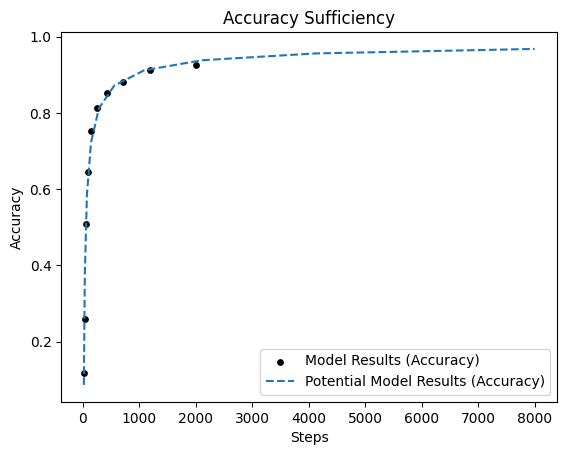

In [14]:
# Plot the output using the convenience function
_ = Sufficiency.plot(output)